# UIUC Grid Demand with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the demand at the University of Illinois. The data used here has minute resolution, but only for
a single year.

The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from pyESN.pyESN import ESN

### Process the Demand Data

In [2]:
all_data = pd.read_csv('../data/2019energydata.csv', 
                       skiprows=1,
                       usecols=['ABBOTT + AMEREN','timestamp','Abbott + Ameren (kw)', 'Unnamed: 18'],
                       parse_dates=[['ABBOTT + AMEREN', 'timestamp']])

In [3]:
all_data.keys()

Index(['ABBOTT + AMEREN_timestamp', 'Unnamed: 18', 'Abbott + Ameren (kw)'], dtype='object')

In [4]:
all_data

,ABBOTT + AMEREN_timestamp,Unnamed: 18,Abbott + Ameren (kw)
0,2018-12-31 22:00:00,OK,37038.000000
1,2018-12-31 22:01:00,OK,36984.000000
2,2018-12-31 22:02:00,OK,36997.000000
3,2018-12-31 22:03:00,OK,37071.000000
4,2018-12-31 22:04:00,OK,37171.000000
...,...,...,...
527036,2020-01-01 21:56:00,OK,36277.500000
527037,2020-01-01 21:57:00,OK,36350.500000
527038,2020-01-01 21:58:00,OK,36242.000000
527039,2020-01-01 21:59:00,OK,36092.000000


In [5]:
all_data.rename(columns={'ABBOTT + AMEREN_timestamp':'time',
                         'Abbott + Ameren (kw)':'kw',
                         'Unnamed: 18':'flag'},
                inplace=True)
all_data

,time,flag,kw
0,2018-12-31 22:00:00,OK,37038.000000
1,2018-12-31 22:01:00,OK,36984.000000
2,2018-12-31 22:02:00,OK,36997.000000
3,2018-12-31 22:03:00,OK,37071.000000
4,2018-12-31 22:04:00,OK,37171.000000
...,...,...,...
527036,2020-01-01 21:56:00,OK,36277.500000
527037,2020-01-01 21:57:00,OK,36350.500000
527038,2020-01-01 21:58:00,OK,36242.000000
527039,2020-01-01 21:59:00,OK,36092.000000


In [6]:
flags = list(all_data.flag.unique())

In [7]:
unreliable = all_data.flag == flags[1]

In [8]:
all_data[unreliable]

,time,flag,kw
125818,2019-03-29 07:58:00,UNRELIABLE,48824.000000
126051,2019-03-29 11:51:00,UNRELIABLE,48306.000000
126058,2019-03-29 11:58:00,UNRELIABLE,49229.500000
131594,2019-04-02 08:14:00,UNRELIABLE,42857.500000
344998,2019-08-28 12:58:00,UNRELIABLE,55690.000000
344999,2019-08-28 12:59:00,UNRELIABLE,24613.000000
345003,2019-08-28 13:03:00,UNRELIABLE,24785.500000
356321,2019-09-05 09:41:00,UNRELIABLE,53423.000000
356322,2019-09-05 09:42:00,UNRELIABLE,53423.000000
374828,2019-09-18 06:08:00,UNRELIABLE,57150.000000


In [9]:
too_low = all_data.kw < 20000

### Some data is bad. Clean it up.

In [10]:
all_data[too_low]

,time,flag,kw
101330,2019-03-12 07:50:00,OK,12352.0
101346,2019-03-12 08:06:00,OK,12369.0
101394,2019-03-12 08:54:00,OK,12742.0
103469,2019-03-13 19:29:00,OK,5761.0
130147,2019-04-01 08:07:00,OK,19671.0
...,...,...,...
385056,2019-09-25 08:36:00,OK,0.0
385078,2019-09-25 08:58:00,OK,0.0
385079,2019-09-25 08:59:00,OK,0.0
385321,2019-09-25 13:01:00,OK,0.0


In [11]:
hourly_demand = pd.read_csv("data/uiuc_demand_data.csv", usecols=['time','kw'])
min_power = np.min(hourly_demand.kw)

In [12]:
less_than_min = all_data.kw < min_power
all_data[less_than_min] = np.nan

In [13]:
all_data.interpolate(method='linear', inplace=True)

In [14]:
all_data.kw.isnull().values.any()

False

In [15]:
# import demand data
demand = np.array(all_data.kw).astype('float64')[:525723]

# normalize
norm = np.linalg.norm(demand, ord=np.inf)
demand_norm = demand/norm

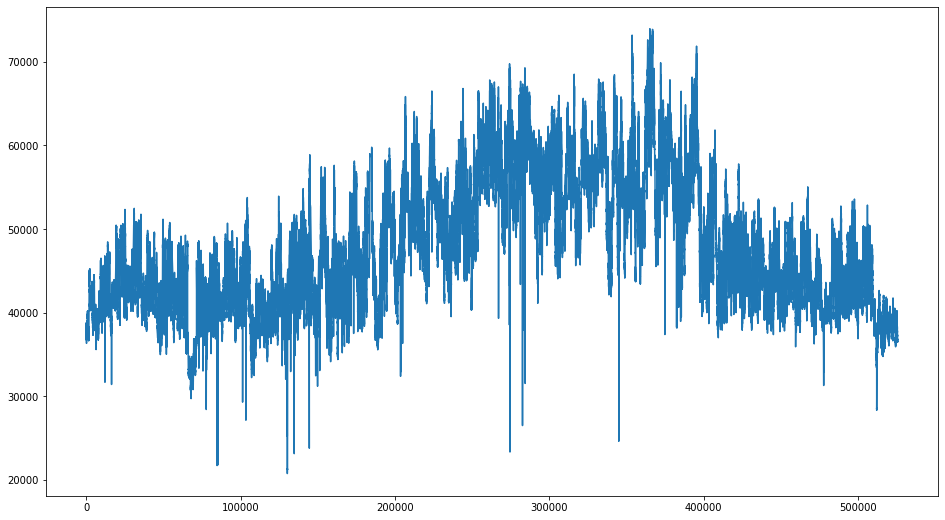

In [16]:
plt.figure(figsize=(16,9))
plt.plot(range(len(demand)), demand)

### 1. Initial Demonstration

In [30]:
params = {'n_reservoir':1500, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':0.9, 
          'noise':0.0007, 
          'future':2880, 
          'window':60, 
          'trainlen':39100}

In [31]:
futureTotal = params['future']
time_range = np.array(all_data.time)
minute_range = np.arange(0, len(time_range), 1)

In [32]:
tic = time.perf_counter()

init_pred = esn_prediction(demand_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 1511.17 seconds
This simulation took 25.19 minutes


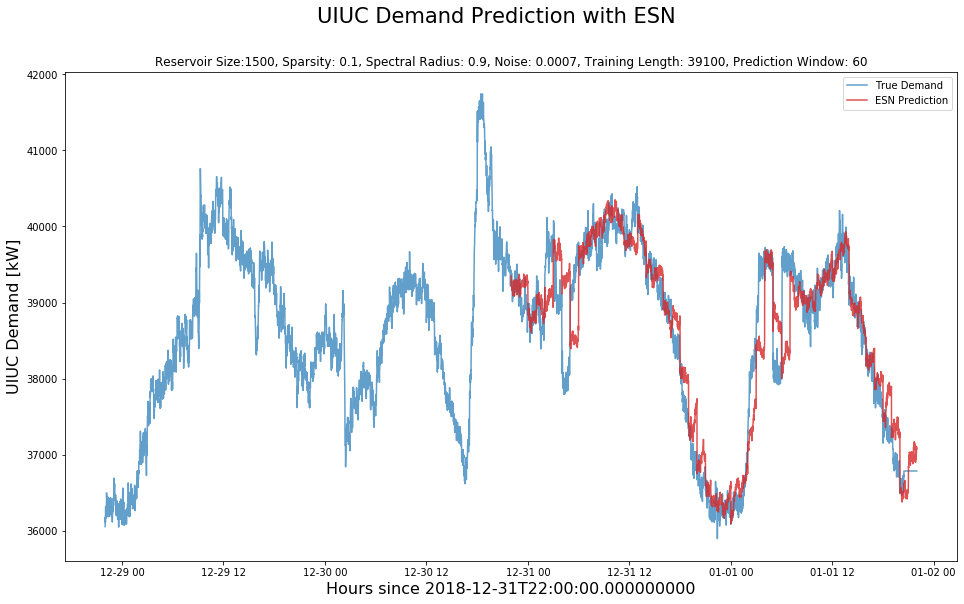

In [33]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*init_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
Spectral Radius = 0.5,Noise = 0.0001, MSE=0.017237812723558607
Spectral Radius = 0.5,Noise = 0.0003, MSE=0.01669984920224759
Spectral Radius = 0.5,Noise = 0.0007, MSE=0.01661882989501562
Spectral Radius = 0.5,Noise = 0.001, MSE=0.01661556418150124
Spectral Radius = 0.5,Noise = 0.003, MSE=0.016896639857110613
Spectral Radius = 0.5,Noise = 0.005, MSE=0.01734779650720097
Spectral Radius = 0.5,Noise = 0.007, MSE=0.017779174273501955
Spectral Radius = 0.5,Noise = 0.01, MSE=0.018320990978053633
Spectral Radius = 0.7,Noise = 0.0001, MSE=0.018063046246629615
Spectral Radius = 0.7,Noise = 0.0003, MSE=0.016843364244258585
Spectral Radius = 0.7,Noise = 0.0007, MSE=0.01653061321700447
Spectral Radius = 0.7,Noise = 0.001, MSE=0.0165107118948982
Spectral Radius = 0.7,Noise = 0.003, MSE=0.016892066241411995
Spectral Radius = 0.7,Noise = 0.005, MSE=0.017514419795708107
Spectral Radius = 0.7,Noise = 0.007, MSE=0.018139343044412764
Spectral Radius = 0.7,Noise = 0.01, MS

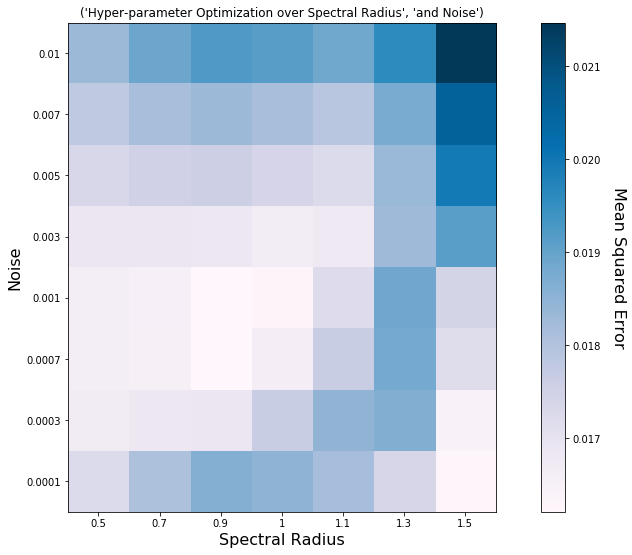

In [21]:
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(demand_norm,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

In [22]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 0.9 
noise = 0.0007


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
Reservoir Size = 600,Sparsity = 0.005, MSE=0.017166666613463836
Reservoir Size = 600,Sparsity = 0.01, MSE=0.017189131724911495
Reservoir Size = 600,Sparsity = 0.03, MSE=0.0165590195162745
Reservoir Size = 600,Sparsity = 0.05, MSE=0.01707207839179433
Reservoir Size = 600,Sparsity = 0.1, MSE=0.017603764418007976
Reservoir Size = 600,Sparsity = 0.15, MSE=0.017601797170711614
Reservoir Size = 600,Sparsity = 0.2, MSE=0.017402959525306315
Reservoir Size = 800,Sparsity = 0.005, MSE=0.019635948214377582
Reservoir Size = 800,Sparsity = 0.01, MSE=0.019388797787601594
Reservoir Size = 800,Sparsity = 0.03, MSE=0.020055978583870294
Reservoir Size = 800,Sparsity = 0.05, MSE=0.019527647262488675
Reservoir Size = 800,Sparsity = 0.1, MSE=0.02113159112884949
Reservoir Size = 800,Sparsity = 0.15, MSE=0.020992397713500522
Reservoir Size = 800,Sparsity = 0.2, MSE=0.0219636509237312
Reservoir Size = 1000,Sparsity = 0.005, MSE=0.016895652355257643
Reservoir Size =

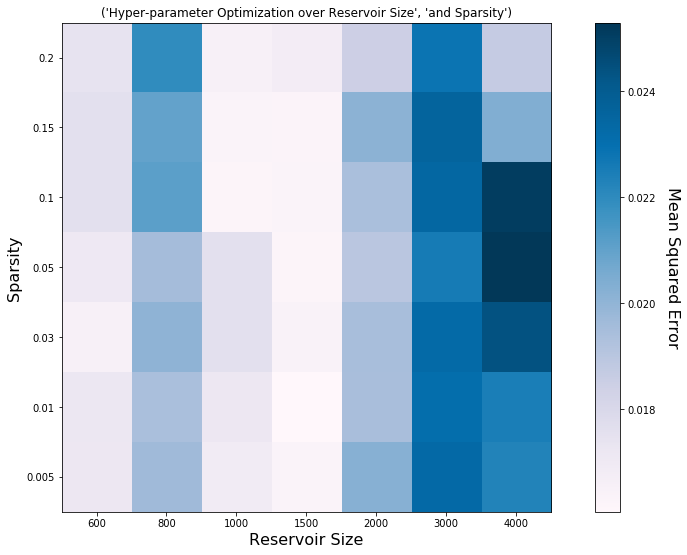

In [23]:
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(demand_norm,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

In [24]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 1500 
sparsity = 0.01


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

In [25]:
trainingLengths = np.arange(4000,525000,300)
trainlen_loss = grid_optimizer(demand_norm,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

Optimizing over ['trainlen']:
trainlen = 4000, MSE=0.02339832352526262
trainlen = 4300, MSE=0.023138754532087892
trainlen = 4600, MSE=0.016435962616793767
trainlen = 4900, MSE=0.01695303626240277
trainlen = 5200, MSE=0.014119243718380997
trainlen = 5500, MSE=0.023087898104012867
trainlen = 5800, MSE=0.024680218848240888
trainlen = 6100, MSE=0.016437281294551333
trainlen = 6400, MSE=0.020367332751635728
trainlen = 6700, MSE=0.019890096505123113
trainlen = 7000, MSE=0.02026258050764204
trainlen = 7300, MSE=0.02393872068856988
trainlen = 7600, MSE=0.022625730044329904
trainlen = 7900, MSE=0.02164328805964697
trainlen = 8200, MSE=0.016939836382338057
trainlen = 8500, MSE=0.016148745266888285
trainlen = 8800, MSE=0.017153706254837343
trainlen = 9100, MSE=0.02115445335482303
trainlen = 9400, MSE=0.015264605641561934
trainlen = 9700, MSE=0.014819194138243475
trainlen = 10000, MSE=0.01605948491175334
trainlen = 10300, MSE=0.01743920247024628
trainlen = 10600, MSE=0.01840972956386905
trainlen =

KeyboardInterrupt: 

In [ ]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

### 5. Optimized Demand Prediction

In [ ]:
tic = time.perf_counter()

opt_pred = esn_prediction(demand_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [ ]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()